In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from utils import prob_clip
from statsmodels.stats.weightstats import DescrStatsW
import random
random.seed(123456)

In [2]:
def pcp(prob, R, m):
    
    n, n_c = prob.shape
    weight = np.ones(n)
    R_ = np.hstack((R[:-1],np.inf))
    idx = random.choices(population=range(n_c), weights=prob[-1], k=m)
    s = np.sum(np.log(prob_clip(prob)[:, idx]), 1)
    max_s = np.max(s)
    weight = np.exp(s - max_s)
    weight /= np.sum(weight)

    return np.sum(weight*(R>=R[-1]))


def pcp0(prob, R, m):
    
    n, n_c = prob.shape
    weight = np.ones(n)
    R_ = np.hstack((R[:-1],np.inf))
    
    s = m * np.sum(prob[-1]*np.log(prob_clip(prob)/prob_clip(prob[-1])), 1)
    max_s = np.max(s)
    weight = np.exp(s - max_s)
    weight /= np.sum(weight)

    return np.sum(weight*(R>=R[-1]))

def pcp1(prob, R, m):
    
    n, n_c = prob.shape
    weight = np.ones(n)
    s = m * np.sum(prob[-1]*np.log(prob_clip(prob[:-1])/prob_clip(prob[-1])), 1)
    max_s = np.max(s)
    weight = np.exp(s - max_s)
    weight /= np.sum(weight)

    return np.sum(weight*(R[:-1]>=R[-1]))

In [3]:
def plot_cdfs(pi_1,pi_2,prop,m,legend=False):
    
    n = 20000
    n_0 =10000
    mean = [5, 10]
    variance = [1, 1]
    R_all = []
    X_all = np.zeros(n)
    prob_all = np.zeros((n,len(pi_1)))
    R_all = np.zeros(n)

    U_all = np.random.binomial(1,prop,size=n)
    for i in range(n):
        if U_all[i]<=0.5:
            X_all[i] = np.random.uniform(-1,0)
            samples = random.choices(population=range(2), weights=[1,0],k=1)[0]
            prob_all[i] = pi_1
        else:
            X_all[i] = np.random.uniform(0,1) 
            samples = random.choices(population=range(2), weights=[0,1],k=1)[0]
            prob_all[i] = pi_2

        R_all[i] = np.random.normal(mean[samples], variance[samples])   


    list_0 = list(range(n_0))
    list_1 = list(range(n_0,n))

    pval_1 = []
    pval_2 = []
    pval_3 = []

    for j in range(n_0,n):

        pval = pcp(prob_all[list_0+[j]], R_all[list_0+[j]],m)
        pval_1.append(pval)

        pval = pcp0(prob_all[list_0+[j]], R_all[list_0+[j]],m)
        pval_2.append(pval)

        pval = pcp1(prob_all[list_0+[j]], R_all[list_0+[j]],m)
        pval_3.append(pval)

    alpha_levels = np.linspace(0, 1.0, 200)

    # Initialize the rejection matrix
    rejection_1 = np.zeros((len(pval_1), len(alpha_levels)), dtype=int)
    rejection_2 = np.zeros((len(pval_2), len(alpha_levels)), dtype=int)
    rejection_3 = np.zeros((len(pval_3), len(alpha_levels)), dtype=int)
    # Compute rejections
    for i, p in enumerate(pval_1):
        rejection_1[i, :] = p <= alpha_levels
    for i, p in enumerate(pval_2):
        rejection_2[i, :] = p <= alpha_levels
    for i, p in enumerate(pval_3):
        rejection_3[i, :] = p <= alpha_levels
    cdf_1 = np.mean(rejection_1,axis=0)
    cdf_2 = np.mean(rejection_2,axis=0)
    cdf_3 = np.mean(rejection_3,axis=0)
    
    fontsize = 22
    labelpad = 10
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    x = np.linspace(-0.01, 1, 500) 
    y = x
    # First subplot
    axs[0].plot(x, y,'black',linewidth=2)
    axs[0].plot(alpha_levels, cdf_2, label="Non-Randomized PCP ($c=0$)", color="tab:blue",linewidth=3)
    axs[0].set_xlabel('Level $\\alpha$', fontsize=fontsize, labelpad=labelpad)
    axs[0].set_ylabel('Mis-coverage rate', fontsize=fontsize, labelpad=labelpad)
    axs[0].set_xlim([-0.01,1])
    axs[0].set_ylim([-0.01,1])
    axs[0].set_xticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    axs[0].set_yticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    axs[0].tick_params(axis='both', which='major', labelsize=fontsize)

    # Second subplot
    axs[1].plot(x, y,'black',linewidth=2)
    axs[1].plot(alpha_levels, cdf_3, label="Non-Randomized PCP ($c=-1$)", color="tab:green",linewidth=3)
    axs[1].set_xlabel('Level $\\alpha$', fontsize=fontsize, labelpad=labelpad)
    axs[1].set_xlim([-0.01,1])
    axs[1].set_ylim([-0.01,1])
    axs[1].set_xticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    axs[1].set_yticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    axs[1].tick_params(axis='both', which='major', labelsize=fontsize)

    # Third subplot
    axs[2].plot(x, y,'black',linewidth=2)
    axs[2].plot(alpha_levels, cdf_1, label="Randomized PCP", color="tab:orange",linewidth=3)
    axs[2].set_xlabel('Level $\\alpha$', fontsize=fontsize, labelpad=labelpad)
    #axs[2].set_ylabel('Miscoverage rate', fontsize=fontsize, labelpad=labelpad)
    axs[2].set_xlim([-0.01,1])
    axs[2].set_ylim([-0.01,1])
    axs[2].set_xticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    axs[2].set_yticks((0, 0.2, 0.4, 0.6, 0.8, 1))
    axs[2].tick_params(axis='both', which='major', labelsize=fontsize)

    # Collect handles and labels from all subplots
    handles1, labels1 = axs[0].get_legend_handles_labels()
    handles2, labels2 = axs[1].get_legend_handles_labels()
    handles3, labels3 = axs[2].get_legend_handles_labels()

    # Combine handles and labels
    handles = handles1 + handles2 + handles3
    labels = ["Non-Randomized PCP ($c=0$)", "Non-Randomized PCP ($c=-1$)", "Randomized PCP"]
    if legend:
    # Add a shared legend below all plots
        fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=fontsize, bbox_to_anchor=(0.5, 1.1))
    plt.show()

In [4]:
def kl(p1,p2):
    return np.exp(-np.sum(p1*np.log((p1+10e-15)/(p2+10e-15))))

In [5]:
pi_1 = np.array([0.8,0.2])
pi_2 = np.array([1,0])
kl_12 = kl(pi_1,pi_2)
kl_21 = kl(pi_2,pi_1)
print(kl_12)
print(kl_21)

0.002614098881478151
0.800000000000002


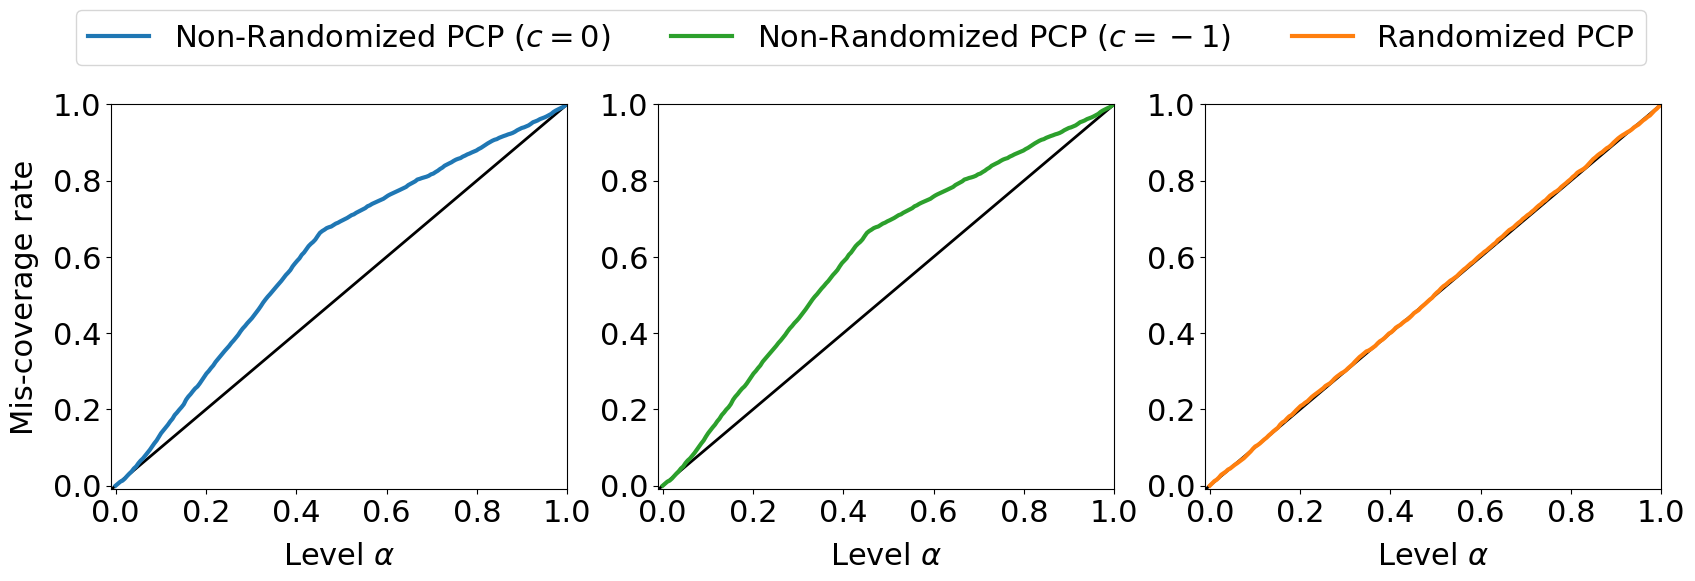

In [6]:
plot_cdfs(pi_1,pi_2, prop=0.4, m=1, legend=True)

In [7]:
pi_1 = np.array([0.8,0.2])
pi_2 = np.array([0.5,0.5])
kl_12 = kl(pi_1,pi_2)
kl_21 = kl(pi_2,pi_1)
print(kl_12)
print(kl_21)

0.8246924442330589
0.800000000000009


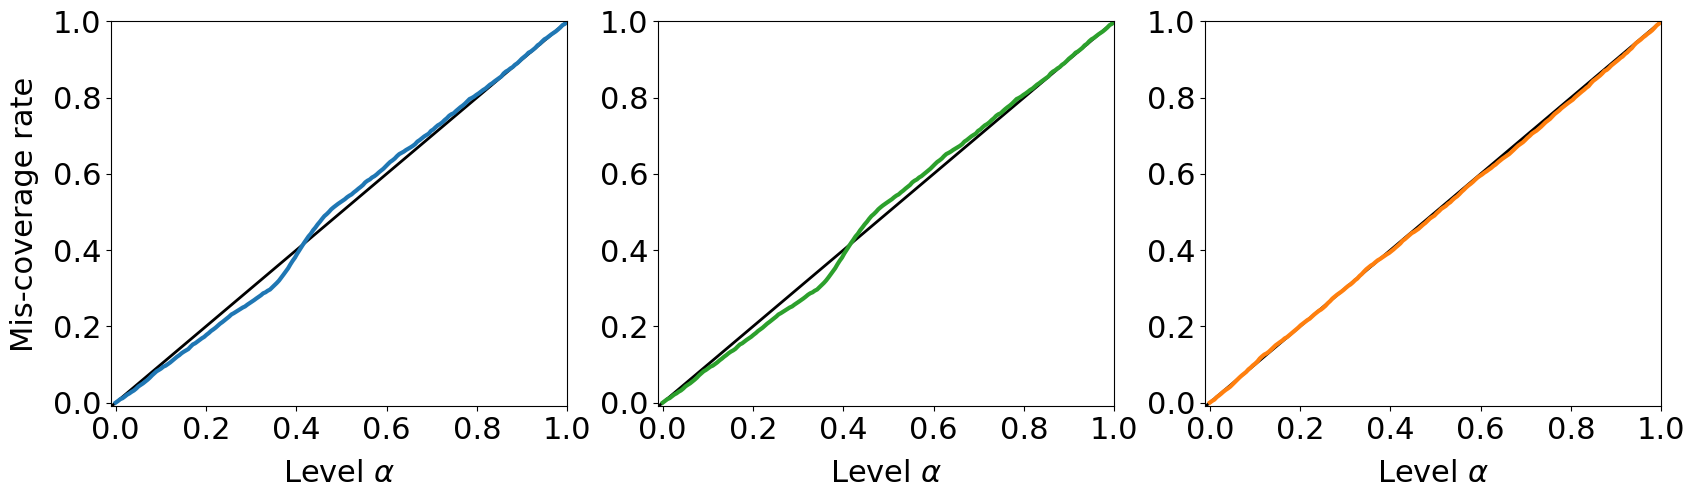

In [8]:
plot_cdfs(pi_1,pi_2, prop=0.4, m=1)